### Game Creation Prediction System

##### Content Page

In [2]:
import mysql.connector as mysql #pip install mysql.connector 
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import requests
import json
import warnings
warnings.filterwarnings('ignore')

import time


### Main Question : How can game developers safely and accurately use user’s behaviour to predict the next big game?

##### To answer this question, we need to break it down into parts : 
##### 1) Does friends playing the game affect whether someone will buy a game?
##### 2) Does Multiplayer games cost more than single player games?
##### 3) Are multiplayer games more popular than single player games?
##### 4) What is the most popular genre? (think we did this alrdy)
##### 5) Does age requirements affect game's popularity?
##### 6) Does common words in descripition affect game's popularity?
##### 7) Does having achievements in game affect playtime, rating , popularity?
##### 8) What is a user's most played genre and how likely are they to play other game genres?



### Data Cleaning

##### Firstly , let us query our database for the list of user accounts, because this sql database has 100m our data, it would be too expensive to constantly querying it for data, so we shall export it to a csv

In [ ]:
#Database Connection (dont run this again , too costly!!)
db_connection = mysql.connect(user="root", password="jajasauce", host="34.143.214.112", database="steam")
cur = db_connection.cursor()

cur.execute("SELECT steamid,personaname FROM Player_Summaries WHERE personastate != 0 LIMIT 100000;") # We shall only limit it to 100,000 because of the large dataset
myresult = cur.fetchall()
df = pd.DataFrame(myresult,columns=['steamid','personaname'])
df.to_csv('playerinfo.csv', index=False) #We exported it to a csv file

##### Next, we have to query steam's API to get the list of games the users has played. This is because our dataset only has userID and not the list of games they played
(https://developer.valvesoftware.com/wiki/Steam_Web_API)

In [ ]:
# Using API 
API = "4141070D32E9CF793B1D9BC8A25C5950"

In [ ]:
steam_data = pd.read_csv("SteamUserData/playerInfo.csv",nrows=20000) #We found out that 100,000 data is too much because each user could have thousands of games, and with just 20,000 users, there is already 500,000 data

#Getting list of User game library data
data1 = {'steamid':[],'gamesid':[],'playtime_forever':[]}
dfGames = pd.DataFrame(data1)

for x in steam_data['steamid']:
    response = requests.get("http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key="+API+"&steamid="+str(x)+"&format=json")
    reply = response.json(); 
    if(reply['response'] == {}):
        continue
    else:
        for y in reply['response']['games']: # save it to data frame instead
            new_row = {'steamid':str(x),'gamesid':y['appid'],'playtime_forever':y['playtime_forever']}
            dfGames = dfGames.append(new_row, ignore_index=True)
          
    
dfGames.to_csv('playerGames.csv', index=False)   


##### Now that we have the list of games the users played lets merge both data together with another dataset of game's infomation (../SteamUserData/App_ID_Info.cs)
##### This is so that we can get the infomation of the games they played and merge it using gameid

In [ ]:
#Firstly lets get the list of players and the games they play
#Lets clean the data by removing games which is free because they have other ways of earning money (DLCs). If App types are not games, we want to remove it as well
User_Data = pd.read_csv("../SteamUserData/playerGames.csv")
App_Info = pd.read_csv("../SteamUserData/App_ID_Info.csv")

Merged = pd.merge(User_Data,App_Info[['gamesid','appType','price','rating','is_Multiplayer']],on=["gamesid"])

#Now lets drop those columns with prices = 0.00 and appType not equal to games
Merged = Merged.drop(Merged[(Merged.price == 0) | (Merged.appType != "game")].index)
#There is now 350k of data instead of 500k of data
#Let us futher merge the table with genres to do EDA
#genres = pd.read_csv("../SteamUserData/Game_Genres.csv")
#UserGame = pd.merge(Merged,genres,on=["gamesid"]) # Game has multiple genres

#### 1) Does friends playing the game affect whether someone will buy a game?


#### First we must call API to check the list of friends a player has and whether they own that same game

In [ ]:
#Get the list of friends for each user , this has to be done by calling APIs
#Using friend list , query whether they got the same game
counter = 0; #limited 100,000 API query a day
Merged = pd.read_csv("../steamdata/PlayerGames_Cleaned.csv")
for x in range(len(Merged['steamid'])):
    response = requests.get("https://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key="+API+"&steamid="+str(Merged['steamid'][x])+"&relationship=friend")
    reply = response.json();
    if(reply == {}):
        continue
    else:
        friendHave = 0;
        for y in reply['friendslist']['friends']: # save it to data frame instead
            if(friendHave == 1):
                break;
            friendResponse = requests.get("http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key="+API+"&steamid="+str(y['steamid'])+"&format=json")
            friendReply = friendResponse.json();
            counter += 1;
            if(friendReply['response'] == {}):
                continue;
            else:
                if(int(friendReply['response']['game_count']) == 0):
                    continue;
                else:
                    for friendGame in friendReply['response']['games']:
                        if(friendGame['appid'] == Merged['gamesid'][x]):
                            friendHave = 1;
                            break;
                                         
    Merged['FriendHasGame'][x] = friendHave;
    Merged.to_csv('PlayerGames_Cleaned.csv', index=False) 

Merged.to_csv('PlayerGames_Cleaned.csv', index=False) 

<AxesSubplot:>

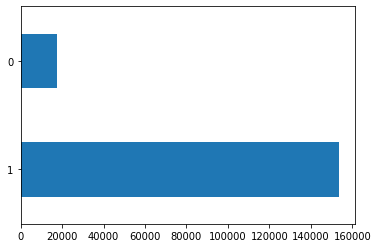

In [ ]:
Merged = pd.read_csv("../SteamUserData/PlayerGames_Cleaned.csv")


Merged['FriendHasGame'].value_counts().plot(kind='barh')

1) We can see that when a friend has the game, they might influence the user to buy and play the game as well

#### Now let us analyze the 2nd question 
#### 2) Does Multiplayer games cost more than single player games?

<AxesSubplot:xlabel='price', ylabel='is_Multiplayer'>

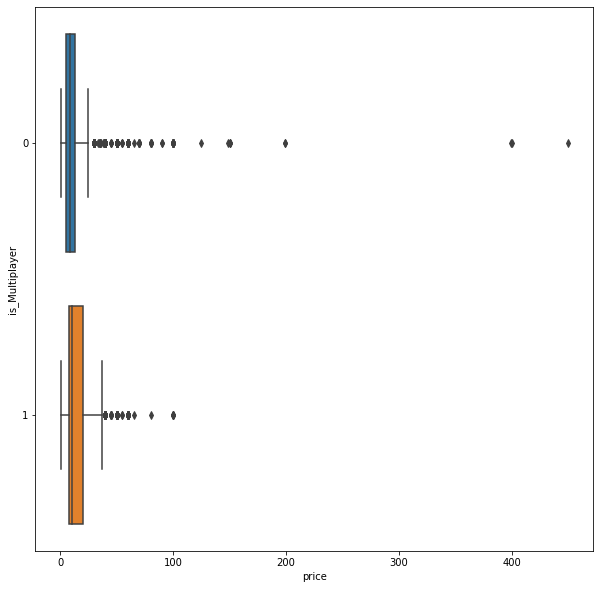

In [ ]:
cost = pd.read_csv("../SteamUserData/App_ID_Info.csv")
#We want to remove appType that are not games.

costCleaned = cost[cost['appType']=='game'] #Clean data to make it only games
costCleaned = costCleaned[cost['price'] > 0] # Remove games that cost $0 because they have other ways of earning money

#now that we have all the list of games, lets do some analysis on it
plt.figure(figsize=(10, 10))
sb.boxplot(data=costCleaned,y="is_Multiplayer",x="price" ,orient = "h")

Now let us remove the outliers so we can get a clearer picture

<AxesSubplot:xlabel='is_Multiplayer', ylabel='price'>

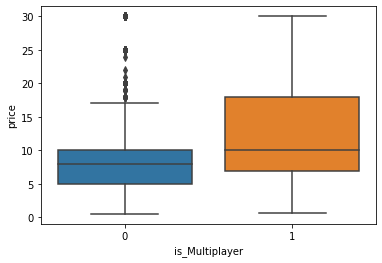

In [ ]:
#Let us remove the outliers so we can get a clearer picture
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

cost1= remove_outlier(costCleaned, "price")
sb.boxplot(data=cost1,x="is_Multiplayer",y="price")

2) We can see that those multiplayer games have a higher interqualite range and median than those non multiplayer games, which shows that multiplayer games, on average, tend to be on the pricer side than non-multiplaye. And therefore, affects the price of a game

### 3) Are multiplayer games more popular than single player games?
To answer this question, we need merge with another dataset that shows average user play time on a game , and more info on that game

In [ ]:
gameData = pd.read_csv("../SteamUserData/App_ID_Info.csv")
gamePopularity = pd.read_csv("../steamdata/steamdata_clean.csv")

gameData =  pd.merge(gameData,gamePopularity[['steam_appid','average_forever']],left_on=["gamesid"],right_on=["steam_appid"])
gameData = gameData.drop(gameData[(gameData.average_forever <= 0)].index) # remove data that cannot find average playtime
gameData


,gamesid,appName,appType,price,release_Date,rating,requiredAge,is_Multiplayer,steam_appid,average_forever
0,10,Counter-Strike,game,9.99,2000-11-01 00:00:00,88,0,1,10,17612
1,20,Team Fortress Classic,game,4.99,1999-04-01 00:00:00,-1,0,1,20,277
2,30,Day of Defeat,game,4.99,2003-05-01 00:00:00,79,0,1,30,187
3,40,Deathmatch Classic,game,4.99,2001-06-01 00:00:00,-1,0,1,40,258
4,50,Half-Life: Opposing Force,game,4.99,1999-11-01 00:00:00,-1,0,1,50,624
...,...,...,...,...,...,...,...,...,...,...
7549,466890,Z.I.O.N.,game,4.99,2016-05-07 00:00:00,-1,0,0,466890,384
7550,466910,Worm.is: The Game,game,0.00,2016-05-04 00:00:00,-1,0,1,466910,68
7551,467000,Insincere,game,39.99,2016-05-12 00:00:00,-1,0,0,467000,257
7553,467310,Rogue Port - Red Nightmare,game,0.00,2016-05-12 00:00:00,-1,0,0,467310,295


Now lets look at the top performing games with the highest amount of user's playtime.

<AxesSubplot:title={'center':'Top 10 Games by average play time'}, xlabel='appName'>

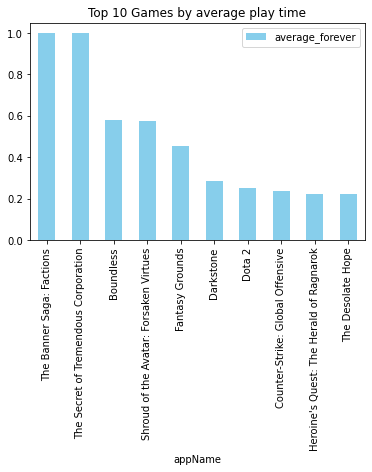

In [ ]:
#Let us normalise the data to make it easier to read
df_max_scaled = gameData.copy()
df_max_scaled = df_max_scaled.nlargest(n=10,columns=["average_forever"])
#df_max_scaled
df_max_scaled["average_forever"] = df_max_scaled["average_forever"]  / df_max_scaled["average_forever"].abs().max()
    
df_max_scaled.plot.bar(x = 'appName', y = 'average_forever', color = 'skyblue', title = 'Top 10 Games by average play time')


In [ ]:
df_max_scaled['is_Multiplayer'].value_counts()

1    6
0    4
Name: is_Multiplayer, dtype: int64

We see that 6 out of 10 games in the top 10 games are multiplayer games, lets increase our datasize to get a clearer picture

In [ ]:
df_max_scaled = gameData.copy()
df_max_scaled = df_max_scaled.nlargest(n=100,columns=["average_forever"])
df_max_scaled['is_Multiplayer'].value_counts()
df_max_scaled = gameData.copy()
df_max_scaled = df_max_scaled.nlargest(n=1000,columns=["average_forever"])
df_max_scaled['is_Multiplayer'].value_counts()

0    603
1    397
Name: is_Multiplayer, dtype: int64

3. This is also quite true for a larger datasize. At the top 100 games and 1000 games based on all user's average play time, about 60% are multiplayer games and about 40% are single player games
We concluded that there is a small higher percent of chance that popular games are multiplayer games based solely on highest average playtime.

Now let us continue and take a look at the average whether there are more multiplayer games with higher average playtime or single player games with higher average playtime.

<AxesSubplot:xlabel='is_Multiplayer', ylabel='average_forever'>

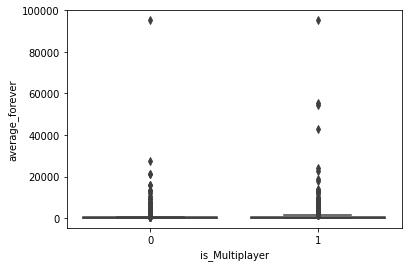

In [ ]:
sb.boxplot(data=gameData,x="is_Multiplayer",y="average_forever")


<AxesSubplot:xlabel='is_Multiplayer', ylabel='average_forever'>

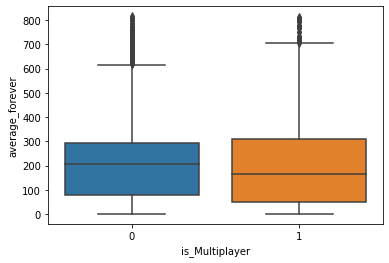

In [ ]:
#Lets remove out outiers
gameData= remove_outlier(gameData, "average_forever")
sb.boxplot(data=gameData,x="is_Multiplayer",y="average_forever")


3) We see that on average, there is not much difference between user's play time when the game is multiplayer or single player. 

So, to futher find a "popularity of a game", we need to see how many people bought the game. Now, lets look at how many people bought the game and whether multiplayer games has more people buying it or not.


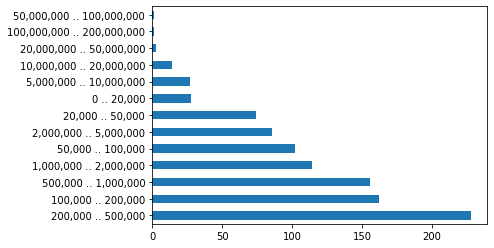

In [3]:
gameData = pd.read_csv("../SteamUserData/App_ID_Info.csv")
gamePopularity = pd.read_csv("../steamdata/steamdata_clean.csv")

gameData =  pd.merge(gameData,gamePopularity[['steam_appid','average_forever','owners']],left_on=["gamesid"],right_on=["steam_appid"])
gameData = gameData.drop(gameData[(gameData.average_forever <= 0)].index) # remove data that cannot find average playtime
gameDataMultiplayer1 = gameData.drop(gameData[(gameData.is_Multiplayer == 0)].index)


#When game is multiplayer
gameDataMultiplayer1['owners'].value_counts().plot(kind='barh')
gameDataMultiplayer1['owners'].value_counts()

#We shall map this caetegorical to a numercial data so that we can get a rough estimate of the number of players
gameDataMultiplayer1['ownersNumerical'] = gameDataMultiplayer1['owners'].map({
    "200,000 .. 500,000": 250000,
    "100,000 .. 200,000": 150000,
    "500,000 .. 1,000,000": 750000,
    "1,000,000 .. 2,000,000": 150000,
    "50,000 .. 100,000": 75000,
    "2,000,000 .. 5,000,000": 3500000,
    "20,000 .. 50,000": 35000,
    "0 .. 20,000": 10000,
    "5,000,000 .. 10,000,000": 7500000,
    "10,000,000 .. 20,000,000": 1500000,
    "20,000,000 .. 50,000,000": 35000000,
    "100,000,000 .. 200,000,000": 150000000,
    "50,000,000 .. 100,000,000": 75000000,
})


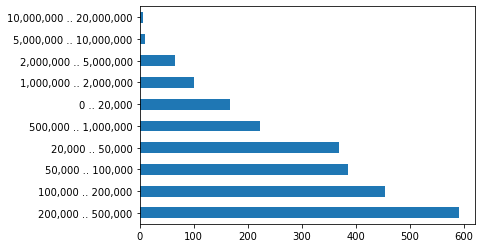

In [4]:
gameDataMultiplayer0 = gameData.drop(gameData[(gameData.is_Multiplayer == 1)].index)


#When game is not multiplayer
gameDataMultiplayer0['owners'].value_counts().plot(kind='barh')
gameDataMultiplayer0['owners'].value_counts()
#We shall map this caetegorical to a numercial data so that we can get a rough estimate of the number of players
gameDataMultiplayer0['ownersNumerical'] = gameDataMultiplayer0['owners'].map({
    "200,000 .. 500,000": 250000,
    "100,000 .. 200,000": 150000,
    "500,000 .. 1,000,000": 750000,
    "1,000,000 .. 2,000,000": 150000,
    "50,000 .. 100,000": 75000,
    "2,000,000 .. 5,000,000": 3500000,
    "20,000 .. 50,000": 35000,
    "0 .. 20,000": 10000,
    "5,000,000 .. 10,000,000": 7500000,
    "10,000,000 .. 20,000,000": 1500000,
    "20,000,000 .. 50,000,000": 35000000,
    "100,000,000 .. 200,000,000": 150000000,
    "50,000,000 .. 100,000,000": 75000000,
})

In [5]:
#Sum of the estimated total number of users buying multiplayer games
gameDataMultiplayer1['ownersNumerical'].sum()

1080420000

In [6]:
#Sum of the estimated total number of users buying single player games
gameDataMultiplayer0['ownersNumerical'].sum()

756235000

4. Based on our estimates, we see that more users buy multiplayer games as compared to single player games. However, if based on users play time, both multiplayer and single player does not have much difference(one 60% the other 40%)

### 5) Does age requirements affect game's popularity?

First we must see how many people own age restricted games and make a comparison between those non age restricted games

In [37]:
gameData = pd.read_csv("../SteamUserData/App_ID_Info.csv")
gamePopularity = pd.read_csv("../steamdata/steamdata_clean.csv")

gameData =  pd.merge(gameData,gamePopularity[['steam_appid','average_forever','owners']],left_on=["gamesid"],right_on=["steam_appid"])
gameData['YesNoAge'] = ""
counter = 0
for x in gameData['requiredAge']:
    if(x > 0):
        gameData['YesNoAge'][counter] = "Yes"
    else:
        gameData['YesNoAge'][counter] = "No"
    counter+=1

<AxesSubplot:xlabel='YesNoAge', ylabel='rating'>

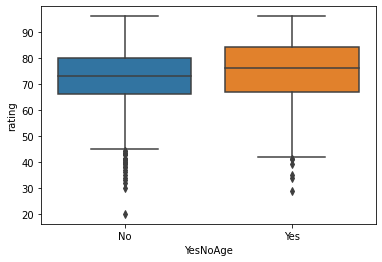

In [38]:
gameData2  = gameData.drop(gameData[(gameData.rating == -1)].index)
sb.boxplot(data=gameData2,x="YesNoAge",y="rating")

Not much difference of age resticted game's rating and no age restricted game rating.

<AxesSubplot:xlabel='YesNoAge', ylabel='ownersNumerical'>

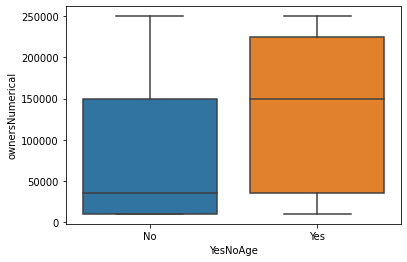

In [39]:
#sb.boxplot(data=gameData,x="YesNoAge",y="rating")

gameData['ownersNumerical'] = gameData['owners'].map({
    "200,000 .. 500,000": 250000,
    "100,000 .. 200,000": 150000,
    "500,000 .. 1,000,000": 750000,
    "1,000,000 .. 2,000,000": 150000,
    "50,000 .. 100,000": 75000,
    "2,000,000 .. 5,000,000": 3500000,
    "20,000 .. 50,000": 35000,
    "0 .. 20,000": 10000,
    "5,000,000 .. 10,000,000": 7500000,
    "10,000,000 .. 20,000,000": 1500000,
    "20,000,000 .. 50,000,000": 35000000,
    "100,000,000 .. 200,000,000": 150000000,
    "50,000,000 .. 100,000,000": 75000000,
})

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

gameData= remove_outlier(gameData, "ownersNumerical")


sb.boxplot(data=gameData,x="YesNoAge",y="ownersNumerical")

5) We see that on average, there is a higher chance of age restricted games being more popular , as there are more people buying such games

#### Does age restriction affect prices?

<AxesSubplot:xlabel='YesNoAge', ylabel='price'>

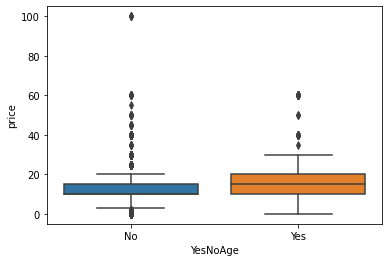

In [66]:
gameData = pd.read_csv("../SteamUserData/AppDataMerged.csv")

counter = 0
gameData['YesNoAge'] = ""
for x in gameData['requiredAge']:
    if(x > 0):
        gameData['YesNoAge'][counter] = "Yes"
    else:
        gameData['YesNoAge'][counter] = "No"
    counter+=1
sb.boxplot(data=gameData2,x="YesNoAge",y="price")

We see that on average, age restricted games does affect prices

### 6) Does common words in game's descripition affect game's popularity?

In [43]:
data = pd.read_csv("../steamdata/steamdata_clean.csv")
data["short_description"] = data["short_description"].fillna("")
from wordcloud import WordCloud, STOPWORDS

name_corpus = ' '.join(data["name"])
name_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 1000, width = 2000).generate(name_corpus)
plt.figure(figsize=(16,8))
plt.imshow(name_wordcloud)
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

### 7) Does having achievements in game affect playtime, rating , popularity?

In [61]:
gameData = pd.read_csv("../SteamUserData/App_ID_Info.csv")
gamePopularity = pd.read_csv("../steamdata/steamdata_clean.csv")
gameAchievement = pd.read_csv("../SteamUserData/Achievement_Percentages.csv")



gameData =  pd.merge(gameData,gamePopularity[['steam_appid','average_forever','owners']],left_on=["gamesid"],right_on=["steam_appid"])
counter = 0
gameData['achievement'] = ""
for x in gameData['gamesid']:
    if x in gameAchievement['gamesid']:
        gameData['achievement'][counter] = "Yes"
    else:
        gameData['achievement'][counter]  = "No"
    counter +=1
    
gameData['ownersNumerical'] = gameData['owners'].map({
    "200,000 .. 500,000": 250000,
    "100,000 .. 200,000": 150000,
    "500,000 .. 1,000,000": 750000,
    "1,000,000 .. 2,000,000": 150000,
    "50,000 .. 100,000": 75000,
    "2,000,000 .. 5,000,000": 3500000,
    "20,000 .. 50,000": 35000,
    "0 .. 20,000": 10000,
    "5,000,000 .. 10,000,000": 7500000,
    "10,000,000 .. 20,000,000": 1500000,
    "20,000,000 .. 50,000,000": 35000000,
    "100,000,000 .. 200,000,000": 150000000,
    "50,000,000 .. 100,000,000": 75000000,
})


gameData.to_csv('../SteamUserData/AppDataMerged.csv', index=False)   

<AxesSubplot:xlabel='achievement', ylabel='ownersNumerical'>

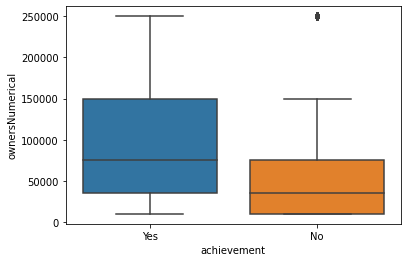

In [59]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

gameData= remove_outlier(gameData, "ownersNumerical")
sb.boxplot(data=gameData,x="achievement",y="ownersNumerical")

We see that having achievements does affect whether people buy games 

Does Achievements Affect cost?

<AxesSubplot:xlabel='achievement', ylabel='price'>

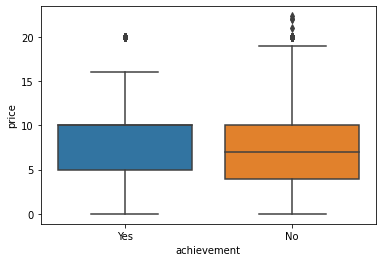

In [63]:
gameData = pd.read_csv("../SteamUserData/AppDataMerged.csv")
gameData= remove_outlier(gameData, "price")
sb.boxplot(data=gameData,x="achievement",y="price")

##### Achievements does not really affect prices

Things that might affect cost prediction: 
1) Multiplayer games cost more than single player games
2) multiplayer games cost most on average
3) Age Restricted Games

Things that affect whether a user will buy a game: 
1) When friends has the game
2) When it is a multiplayer game
3) Achievements
4) Age restricted games


#### Now lets look at the correlation between those things affected 

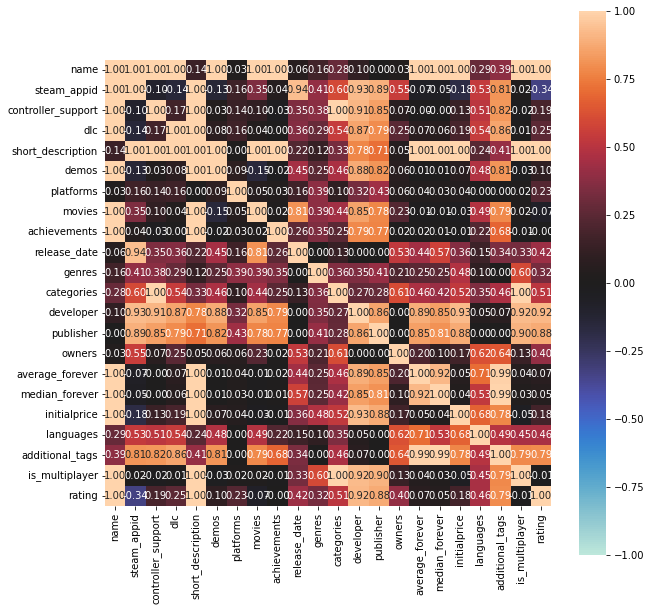

,name,steam_appid,controller_support,dlc,short_description,demos,platforms,movies,achievements,release_date,genres,categories,developer,publisher,owners,average_forever,median_forever,initialprice,languages,additional_tags,is_multiplayer,rating
name,1.00,1.00,1.00,1.00,0.14,1.00,0.03,1.00,1.00,0.06,0.16,0.28,0.10,0.00,0.03,1.00,1.00,1.00,0.29,0.39,1.00,1.00
steam_appid,1.00,1.00,-0.10,-0.14,1.00,-0.13,0.16,0.35,0.04,0.94,0.41,0.60,0.93,0.89,0.55,-0.07,-0.05,-0.18,0.53,0.81,0.02,-0.34
controller_support,1.00,-0.10,1.00,0.17,1.00,0.03,0.14,0.10,-0.03,0.35,0.38,1.00,0.91,0.85,0.07,-0.00,-0.00,0.13,0.51,0.82,-0.02,0.19
dlc,1.00,-0.14,0.17,1.00,1.00,0.08,0.16,0.04,0.00,0.36,0.29,0.54,0.87,0.79,0.25,0.07,0.06,0.19,0.54,0.86,0.01,0.25
short_description,0.14,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.22,0.12,0.33,0.78,0.71,0.05,1.00,1.00,1.00,0.24,0.41,1.00,1.00
demos,1.00,-0.13,0.03,0.08,1.00,1.00,0.09,-0.15,-0.02,0.45,0.25,0.46,0.88,0.82,0.06,0.01,0.01,0.07,0.48,0.81,-0.03,0.10
platforms,0.03,0.16,0.14,0.16,0.00,0.09,1.00,0.05,0.03,0.16,0.39,0.10,0.32,0.43,0.06,0.04,0.03,0.04,0.00,0.00,0.02,0.23
movies,1.00,0.35,0.10,0.04,1.00,-0.15,0.05,1.00,0.02,0.81,0.39,0.44,0.85,0.78,0.23,-0.01,-0.01,-0.03,0.49,0.79,0.02,-0.07
achievements,1.00,0.04,-0.03,0.00,1.00,-0.02,0.03,0.02,1.00,0.26,0.35,0.25,0.79,0.77,0.02,0.02,0.01,-0.01,0.22,0.68,-0.01,-0.00
release_date,0.06,0.94,0.35,0.36,0.22,0.45,0.16,0.81,0.26,1.00,0.00,0.13,0.00,0.00,0.53,0.44,0.57,0.36,0.15,0.34,0.33,0.42


In [8]:
from dython.nominal import associations
from dython.nominal import identify_nominal_columns


gameData = pd.read_csv("../steamdata/steamdata_clean.csv")
categorical_features=identify_nominal_columns(gameData)
complete_correlation= associations(gameData, filename= 'complete_correlation.png', figsize=(10,10))
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [4]:
gameData = pd.read_csv("../steamdata/steamdata_clean.csv")
gameData

,name,steam_appid,controller_support,dlc,short_description,demos,platforms,movies,achievements,release_date,...,developer,publisher,owners,average_forever,median_forever,initialprice,languages,additional_tags,is_multiplayer,rating
0,Counter-Strike,10,0,0,Play the world's number 1 online action game. ...,0,windows;mac;linux,0,0,2000-11-01,...,Valve,Valve,"10,000,000 .. 20,000,000",17612,317,9.99,English;French;German;Italian;Spanish - Spain;...,Survival;Competitive;Shooter;Old School;1990's...,1.0,97.3
1,Team Fortress Classic,20,0,0,One of the most popular online action games of...,0,windows;mac;linux,0,0,1999-04-01,...,Valve,Valve,"5,000,000 .. 10,000,000",277,62,4.99,English;French;German;Italian;Spanish - Spain;...,Competitive;Mod;Shooter;Old School;1990's;Clas...,1.0,82.8
2,Day of Defeat,30,0,0,Enlist in an intense brand of Axis vs. Allied ...,0,windows;mac;linux,0,0,2003-05-01,...,Valve,Valve,"5,000,000 .. 10,000,000",187,34,4.99,English;French;German;Italian;Spanish - Spain,World War I;Shooter;War;Classic;Military;World...,1.0,88.6
3,Deathmatch Classic,40,0,0,Enjoy fast-paced multiplayer gaming with Death...,0,windows;mac;linux,0,0,2001-06-01,...,Valve,Valve,"5,000,000 .. 10,000,000",258,184,4.99,English;French;German;Italian;Spanish - Spain;...,Shooter;Classic;FPS;Multiplayer;First-Person;A...,1.0,80.7
4,Half-Life: Opposing Force,50,0,0,Return to the Black Mesa Research Facility as ...,0,windows;mac;linux,0,0,1999-11-01,...,Gearbox Software,Valve,"5,000,000 .. 10,000,000",624,415,4.99,English;French;German;Korean,Shooter;Story Rich;1990's;Great Soundtrack;Cla...,0.0,94.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25301,Room of Pandora,1065230,0,0,The Room of Pandora is a third-person interact...,0,windows,1,7,2019-04-24,...,SHEN JIAWEI,SHEN JIAWEI,"0 .. 20,000",0,0,2.99,English;Japanese;Simplified Chinese;Traditiona...,Puzzle,0.0,43.8
25302,Cyber Gun,1065570,0,0,Cyber Gun is a hardcore first-person shooter w...,0,windows,1,0,2019-04-23,...,Semyon Maximov,BekkerDev Studio,"0 .. 20,000",0,0,1.99,English,Cyberpunk;Difficult;Classic;Colorful;Minimalis...,0.0,56.5
25303,Super Star Blast,1065650,1,0,Super Star Blast is a space based game with ch...,0,windows,1,24,2019-04-24,...,EntwicklerX,EntwicklerX,"0 .. 20,000",0,0,4.99,English,NaN,0.0,0.0
25304,New Yankee 7: Deer Hunters,1066700,0,0,Pursue a snow-white deer through an enchanted ...,0,windows;mac,1,0,2019-04-17,...,Yustas Game Studio,Alawar Entertainment,"0 .. 20,000",0,0,6.99,English;German;Korean;Russian,NaN,0.0,34.2
